In [1]:
# Nested Dissection
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
from scipy.sparse.linalg import spsolve
import scipy
import matplotlib.pylab as plt_pylab


# Set up a test problem of solving
PDE: $$ -\nabla\cdot(a(x,y)\nabla(u)) = f(x,y)$$
Domain: $$\Omega = [0,1]^2$$
Boundary condition on $\partial\Omega$: $$u = 0$$
Heat conductance function: $$a(x,y) = 1+x+2y^2$$
The right-hand side $f$, the heat source function, is chosen so that the exact solution is $$u = x(1-x)y(1-y)$$


In [2]:
def TestMatrix(nx,ny):
    # the domain is discretized to an nx-by-ny grid
    # This function returns A, u_exact, b for the discretized PDE, 
    # Au_exact = b
    # u_exact is the variable solution
    # A is (nx-2)*(ny-2)-by-(nx-2)*(ny-2) matrix, b, solution are (nx-2)*(ny-2)-by-1 vectors
    nx1 = nx-1
    ny1 = ny-1
    hx = 1.0/nx1
    hy = 1.0/ny1
    N = (nx-2)*(ny-2)
    tx = np.linspace(0,1,nx)
    ty = np.linspace(0,1,ny)
    xgrid,ygrid = np.meshgrid(tx,ty)
    uexact = xgrid*(1-xgrid)*ygrid*(1-ygrid)
    a = 1 + xgrid + 2*ygrid**2
    f = differential_operator(hx,hy,uexact,a)
    A = make_matrix(a,hx,hy)
    # the right-hand side is the right-hand side reshaped into a 1D array
    b = np.reshape(np.transpose(f),(N,))
    # solution is the exact solution at interior points reshaped into a 1D array
    solution = np.reshape(np.transpose(uexact[np.ix_(np.arange(1,ny1),np.arange(1,nx1))]),(N,))
    return A,b,solution
    

def differential_operator(hx,hy,u,a):
    # this function creates the discrete differential operator applied to the input grid function u
    ny,nx = np.shape(u)
    hx2 = hx**2
    hy2 = hy**2
    
    a_south = 0.5*(a + np.roll(a,1,axis = 0))/hy2
    a_north = 0.5*(a + np.roll(a,-1,axis = 0))/hy2
    a_west = 0.5*(a + np.roll(a,1,axis = 1))/hx2
    a_east = 0.5*(a + np.roll(a,-1,axis = 1))/hx2
    a_point = a_south + a_north + a_east + a_west
    I = np.ix_(np.arange(1,ny-1),np.arange(1,nx-1))
    Isouth = np.ix_(np.arange(0,ny-2),np.arange(1,nx-1))
    Inorth = np.ix_(np.arange(2,ny),np.arange(1,nx-1))
    Ieast = np.ix_(np.arange(1,ny-1),np.arange(2,nx))
    Iwest = np.ix_(np.arange(1,ny-1),np.arange(0,nx-2))
    
    Lu = (a_point[I]*u[I] - a_south[I]*u[Isouth] - a_north[I]*u[Inorth]\
         -a_east[I]*u[Ieast] - a_west[I]*u[Iwest])
    return Lu

def make_matrix(a,hx,hy):
    # makes discretized differential operator
    # -grad*(a(x,y)*grad(u)) 
    # with homogeneous dirichlet boundary conditions
    ny,nx = np.shape(a)
    nx2 = nx-2
    ny2 = ny-2
    N = (nx-2)*(ny-2) # the matrix A is N-by-N
    hx2 = hx**2
    hy2 = hy**2

    # compute the coefficients
    c_south = 0.5*(a + np.roll(a,1,axis = 0))/hy2
    c_north = 0.5*(a + np.roll(a,-1,axis = 0))/hy2
    c_west = 0.5*(a + np.roll(a,1,axis = 1))/hx2
    c_east = 0.5*(a + np.roll(a,-1,axis = 1))/hx2

    # make index array of interior indices
    I = np.ix_(np.arange(1,ny-1),np.arange(1,nx-1))

    cS = np.reshape(np.transpose(c_south[I]),(N,))
    cN = np.reshape(np.transpose(c_north[I]),(N,))
    cE = np.reshape(np.transpose(c_east[I]),(N,))
    cW = np.reshape(np.transpose(c_west[I]),(N,))
    cP = cN+cE+cW+cS
    # A must have an nx2-by-nx2 block structure, each block is of size ny2-by-ny2
#    A = sc.spdiags([np.roll(-cW,-1),np.roll(-cS,-ny2),cP,np.roll(-cN,ny2),np.roll(-cE,1)],\
#                  np.array([-ny2,-1,0,1,ny2]),N,N)
    A = sc.spdiags([-np.roll(cW,-ny2),-np.roll(cS,-1),cP,-np.roll(cN,1),-np.roll(cE,ny2)],\
                  np.array([-ny2,-1,0,1,ny2]),N,N)
    A = sc.lil_matrix(A)
    # implement homogeneous Dirichlet boundary conditions
    for j in range(1,nx2):
        A[ny2*j-1,ny2*j] = 0.0  
        A[ny2*j,ny2*j-1] = 0.0
    return A
    

# nx = 3
# ny = 3
# A,b,sol = TestMatrix(nx+2,ny+2)
# print(A.todense())
# print(b)
# print(sol)
# print(np.matmul(A.toarray(),sol))
# x = np.linalg.solve(A.toarray(),b)
# print(x)
# print(np.reshape(np.transpose(x),(3,3)))
# print(np.matmul(A.toarray(),x))
# print(90.*x[0] -25*x[1] -24*x[3])
# print(90.*sol[0] -25*sol[1] -24*sol[3])
# print(x[0])
# print(sol[0])
# print(np.matmul(A.toarray(),x-sol))


# A = sc.csc_matrix(A)
# x = spsolve(A,np.transpose(b))
# print(x)
# print(np.reshape(np.transpose(x),(ny-2,nx-2)))

# from scipy import sparse
# from numpy import array
# I = array([0,3,1,0])
# J = array([0,3,1,2])
# V = array([4,5,7,9])
# A = sparse.coo_matrix((V,(I,J)),shape=(4,4))
# from scipy.sparse import coo_array
# test_coo = coo_array((3, 4), dtype=np.int8).toarray()
# print(test_coo)

# row  = np.array([0, 3, 1, 0])
# col  = np.array([0, 3, 1, 2])
# data = np.array([4, 5, 7, 9])
# test_coo = coo_array((data, (row, col)), shape=(4, 4)).toarray()
# print(test_coo)

In [3]:
# LU without pivoting
# source: https://mail.python.org/pipermail/scipy-user/2006-May/007854.html
def lunopiv(A,ptol):
    m,n = np.shape(A)
    for i in np.arange(0,n):
        pivot = A[i,i]
        if abs(pivot) < ptol:
            print("zero pivot encountered")
            break
        for k in np.arange(i+1,n):
            A[k,i] = A[k,i]/pivot
            A[k,i+1:n] = A[k,i+1:n] - A[k,i]*A[i,i+1:n]
    L = np.eye(n)+np.tril(A,-1)
    U = np.triu(A)
    return L,U


In [4]:
def MyDissection(A,nx_grid,ny_grid,level):
    A0 = A
    ptol = 1.0e-12 # tolerance for LU without pivoting
    # if level is even do vertical split
    # if level is odd do horizontal split
    N_grid = nx_grid*ny_grid # grid size
#     print(f"MyDissection: nx_grid = {nx_grid}, ny_grid = {ny_grid}, level = {level}")
    if level%2 == 0: # vertical split
        if nx_grid >= 3:
#             print("Vertical split")
            nx_Omega1 = nx_grid//2 # the number of columns in Omega1
            N_Omega1 = nx_Omega1*ny_grid # size of Omega1
            ind_Omega3 = np.arange(N_Omega1,N_Omega1 + ny_grid,dtype = np.int32) # indices of Omega3
            N_Omega3 = np.size(ind_Omega3) # size of Omega3
            ind_Omega1 = np.arange(N_Omega1,dtype = np.int32) # indices of Omega1
            ind_Omega2 = np.arange(N_Omega1+N_Omega3,N_grid,dtype = np.int32) # indices of Omega2
            N_Omega2 = np.size(ind_Omega2) # size of Omega2
            ny_Omega1 = ny_grid
            nx_Omega2 = nx_grid - nx_Omega1 - 1
            ny_Omega2 = ny_grid
        else:
#             print("Do PLU")
#            P, L, U = scipy.linalg.lu(A) # A = P @ L @ U
            L,U = lunopiv(A,ptol)
            P = np.eye(N_grid)
            return P, L, U, A
    else: # horizontal split
        if ny_grid >= 3:
#             print("Horizontal split")
            ny_Omega1 = ny_grid//2 # the number of rows in Omega1
            N_Omega1 = ny_Omega1*nx_grid # size of Omega1
            ind_Omega3 = np.arange(ny_Omega1,N_grid,ny_grid,dtype = np.int32) # indices of Omega3
            ny_Omega2 = ny_grid - ny_Omega1 - 1
            ind_Omega1 = np.zeros(ny_Omega1*nx_grid,dtype = np.int32)
            ind_Omega2 = np.zeros(ny_Omega2*nx_grid,dtype = np.int32)
            if nx_grid > 1:
                for k in range(nx_grid):
                    ind1_start = k*ny_grid
                    ind2_start = k*ny_grid + ny_Omega1 + 1
                    j1_start = k*ny_Omega1
                    j2_start = k*ny_Omega2
                    ind_Omega1[j1_start:j1_start+ny_Omega1]=np.arange(ind1_start,ind1_start+ny_Omega1,dtype = np.int32)
                    ind_Omega2[j2_start:j2_start+ny_Omega2]=np.arange(ind2_start,ind2_start+ny_Omega2,dtype = np.int32)
            else: # case nx_grid == 1
                ind_Omega1 = np.arange(ny_Omega1,dtype = np.int32)
                ind_Omega2 = np.arange(ny_Omega1+1,ny_Omega1+1+ny_Omega2,dtype = np.int32)
            N_Omega2 = np.size(ind_Omega2) # size of Omega2
            N_Omega3 = np.size(ind_Omega3) # size of Omega3
            nx_Omega1 = nx_grid
            nx_Omega2 = nx_grid
        else:
#             print("Do PLU")
#             P, L, U = scipy.linalg.lu(A) # A = P @ L @ U
            L,U = lunopiv(A,ptol)
            P = np.eye(N_grid)
            return P, L, U, A
    I11 = np.ix_(ind_Omega1,ind_Omega1)
    I22 = np.ix_(ind_Omega2,ind_Omega2)
    A11 = A[I11]
    A22 = A[I22]
    
    # go to the next level of recursion toprocess the subdomains Omega1 and Omega2
    P11,L11,U11,A11 = MyDissection(A11,nx_Omega1,ny_Omega1,level+1)
    P22,L22,U22,A22 = MyDissection(A22,nx_Omega2,ny_Omega2,level+1)

    # compute the permutation matrix
    # the matrix P1 places P11 and P22 to places corresponding to their indices in the indexing system
    P1 = np.eye(N_grid)
    P1[np.ix_(ind_Omega1,ind_Omega1)] = P11
    P1[np.ix_(ind_Omega2,ind_Omega2)] = P22
    # the matrix P permutes the blocks P11,P22,P33 for the new indexing system
    # template: coo_array((data, (row, col)), shape=(4, 4)).toarray() 
    P = sc.coo_array((np.ones(N_grid),(np.arange(N_grid),np.concatenate((ind_Omega1,ind_Omega2,ind_Omega3)))),\
                     shape=(N_grid, N_grid)).toarray()
    P = P @ P1
    A = P @ A0 @ np.transpose(P)
    
    # extract nonzero blocks of A
    new_ind_Omega1 = np.arange(N_Omega1,dtype = np.int32)
    new_ind_Omega2 = np.arange(N_Omega1,N_Omega1 + N_Omega2,dtype = np.int32)
    new_ind_Omega3 = np.arange(N_Omega1 + N_Omega2,N_grid,dtype = np.int32)
#     I11 = np.ix_(new_ind_Omega1,new_ind_Omega1)
#     I22 = np.ix_(new_ind_Omega2,new_ind_Omega2)
    I33 = np.ix_(new_ind_Omega3,new_ind_Omega3)
    I13 = np.ix_(new_ind_Omega1,new_ind_Omega3)
    I23 = np.ix_(new_ind_Omega2,new_ind_Omega3)
    I31 = np.ix_(new_ind_Omega3,new_ind_Omega1)
    I32 = np.ix_(new_ind_Omega3,new_ind_Omega2)
 
    #   Compute Schur complement
    # S33 = A33 - A31*(U11\(L11\A13)) - A32*(U22\(L22\A23))
    # template:    scipy.sparse.linalg.spsolve_triangular(A, b, lower=True, overwrite_A=False, 
    #    overwrite_b=False, unit_diagonal=False)[source]#
    aux1 = sc.linalg.spsolve_triangular(L11,A[I13],lower=True)
    aux1 = sc.linalg.spsolve_triangular(U11,aux1,lower=False)    
    aux1 = A[I31] @ aux1
    aux2 = sc.linalg.spsolve_triangular(L22,A[I23],lower=True)
    aux2 = sc.linalg.spsolve_triangular(U22,aux2,lower=False)    
    aux2 = A[I32] @ aux2
    S33 = A[I33] - aux1 - aux2
    
    # find the LU of the Schur complement
    # here we assume that P33 is identity
#     P33,L33,U33 = scipy.linalg.lu(S33)
    ny_S33,nx_S33 = np.shape(S33)
#     print(f"Do PLU of the Schur complement S33 {ny_S33}-by-{nx_S33}")
    L33,U33 = lunopiv(S33,ptol)
    # form LU decomposition of A
    L = sc.block_diag((L11,L22,L33)).toarray()
    L[I31] = np.transpose(sc.linalg.spsolve_triangular(np.transpose(U11),np.transpose(A[I31]),lower=True))
    L[I32] = np.transpose(sc.linalg.spsolve_triangular(np.transpose(U22),np.transpose(A[I32]),lower=True))
    U = sc.block_diag((U11,U22,U33)).toarray()
    U[I13] = sc.linalg.spsolve_triangular(L11,A[I13],lower=True)
    U[I23] = sc.linalg.spsolve_triangular(L22,A[I23],lower=True)
    # plot P
#     print(f"Update PLU of A of size {nx_grid}-by-{ny_grid}")
#     plt_pylab.spy(P,marker = "s",markersize = 15./nx_grid)
#     plt_pylab.show()
    return P,L,U,A

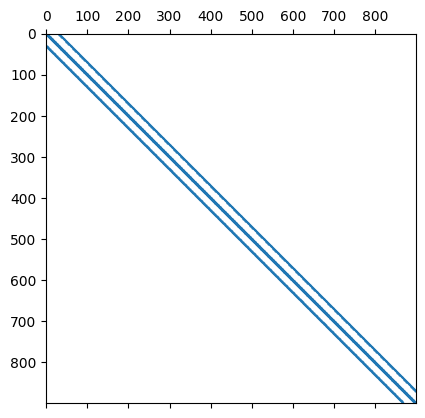

In [5]:
# Problem setup
nx = 30
ny = 30
A,b,sol = TestMatrix(nx+2,ny+2)
# Plot sparsity pattern of the original matrix A
plt_pylab.spy(A,marker = "s",markersize = 0.5)
plt_pylab.show()

/tmp/ipykernel_3163722/1450336199.py:94: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  aux1 = sc.linalg.spsolve_triangular(L11,A[I13],lower=True)
/tmp/ipykernel_3163722/1450336199.py:95: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  aux1 = sc.linalg.spsolve_triangular(U11,aux1,lower=False)
/tmp/ipykernel_3163722/1450336199.py:97: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  aux2 = sc.linalg.spsolve_triangular(L22,A[I23],lower=True)
/tmp/ipykernel_3163722/1450336199.py:98: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  aux2 = sc.linalg.spsolve_triangular(U22,aux2,lower=False)
/tmp/ipykernel_3163722/1450336199.py:110: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  L[I31] = np.transpose(sc.linalg.spsolve_triangular(np.transpose(U11),np.transpose(A[I31]),lower=True))
/t

norm(sol-x) =  1.548357078838834e-15


/tmp/ipykernel_3163722/1570127283.py:18: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  y = sc.linalg.spsolve_triangular(L,Pb,lower = True)
/tmp/ipykernel_3163722/1570127283.py:19: SparseEfficiencyWarning: CSC or CSR matrix format is required. Converting to CSC matrix.
  x_aux = sc.linalg.spsolve_triangular(U,y,lower = False)


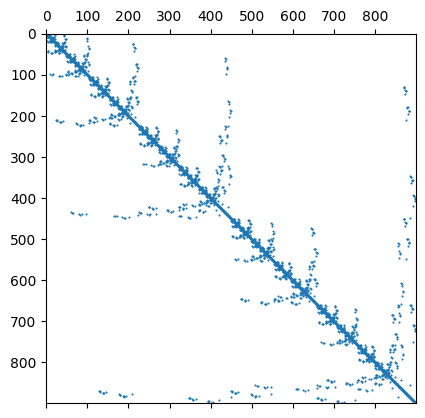

In [6]:
level = 0
# make A a dense matrix
A = A.toarray()
[P,L,U,A] = MyDissection(A,nx,ny,level)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve_triangular.html
# Nested Dissection algorithm solves Ax=b
# It rearranges A using a permutation matrix P that it constructs
# Note: P' = P^{-1}
# Hence it solves PAP'Px = Pb
# It decomposes PAP' = LU
# Hence we need to solve LUPx = Pb
# It first solves Ly = Pb by y = L\(Pb)
# Then it solves UPx = y by x = P'(U\y)

# scipy.sparse.linalg.spsolve_triangular(A, b, lower=True, overwrite_A=False, 
# overwrite_b=False, unit_diagonal=False)[source]
Pb = P.dot(b)
y = sc.linalg.spsolve_triangular(L,Pb,lower = True)
x_aux = sc.linalg.spsolve_triangular(U,y,lower = False)
x = np.transpose(P).dot(x_aux)

print("norm(sol-x) = ",np.linalg.norm(sol-x))

A = sc.csr_matrix(A)
plt_pylab.spy(A,marker = "s",markersize = 0.5)
plt_pylab.show()